In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_ftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [6]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6991542286634957


### Sample only PRs by first-time contributors

In [7]:
# Filters data
df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=426832
class_imbalance=1.9236870766006124
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosy

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,4.268320e+05,4.268320e+05,426832.000000,426832.0,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,...,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000,426832.000000
mean,1.213651e+08,5.131872e+06,584.979807,0.0,0.265203,0.023931,0.256362,0.024847,0.491480,0.106394,...,0.002768,0.004929,0.057686,0.094571,0.004174,0.007872,0.048752,0.007892,0.012933,0.006278
std,9.542933e+07,8.008834e+06,1733.884021,0.0,0.409386,0.149548,0.405401,0.150628,0.223246,0.060923,...,0.025482,0.040209,0.101355,0.149757,0.033526,0.054303,0.088964,0.036228,0.064506,0.027593
min,1.153000e+03,1.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.799896e+07,4.987750e+05,30.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.334352,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.011235e+08,1.681449e+06,122.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.502926,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.888974e+08,6.317507e+06,469.000000,0.0,0.666667,0.000000,0.647059,0.000000,0.662211,0.119279,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.064858,0.000000,0.000000,0.000000
max,3.617756e+08,5.973444e+07,82976.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759557,1.000000,1.000000,1.000000,1.000000,0.999543,1.000000,0.824499,0.951250,0.646942


## Model Creation

In [8]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [9]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [10]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [11]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.7672843989410304, 'precision': 0.7955911174460227, 'recall': 0.8714450456843786, 'f1': 0.8317923186344238}


Confusion matrix:
[[16381 12620]
 [ 7246 49119]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.56      0.62     29001
        True       0.80      0.87      0.83     56365

    accuracy                           0.77     85366
   macro avg       0.74      0.72      0.73     85366
weighted avg       0.76      0.77      0.76     85366


metrics={'accuracy': 0.7676619771105931, 'precision': 0.7932627091273173, 'recall': 0.8747729458275457, 'f1': 0.8320262877081251}


Confusion matrix:
[[16411 12802]
 [ 7032 49122]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29213
        True       0.79      0.87      0.83     56154

    accuracy                           0.77     85367
   macro avg       0.75      0.72      0.73     85367
weighted avg       0.76      0.77      0.76     85367


metrics={'accuracy': 0.7653308655569482, 'precision': 0.7913087009883083, 'recall': 0.8732868777957976, 'f1': 0.8302791544880757}


Confusion matrix:
[[16333 12923]
 [ 7110 49001]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29256
        True       0.79      0.87      0.83     56111

    accuracy                           0.77     85367
   macro avg       0.74      0.72      0.73     85367
weighted avg       0.76      0.77      0.76     85367


metrics={'accuracy': 0.7670618278940093, 'precision': 0.7933943171699183, 'recall': 0.87307582668187, 'f1': 0.831330104416717}


Confusion matrix:
[[16477 12761]
 [ 7124 49004]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29238
        True       0.79      0.87      0.83     56128

    accuracy                           0.77     85366
   macro avg       0.75      0.72      0.73     85366
weighted avg       0.76      0.77      0.76     85366


metrics={'accuracy': 0.7674601129255207, 'precision': 0.7919863322803172, 'recall': 0.8761656830055453, 'f1': 0.8319520516054755}


Confusion matrix:
[[16377 12906]
 [ 6945 49138]]


Classification report:

              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29283
        True       0.79      0.88      0.83     56083

    accuracy                           0.77     85366
   macro avg       0.75      0.72      0.73     85366
weighted avg       0.76      0.77      0.76     85366



Performance metrics full model:
f1_scores=[0.8317923186344238, 0.8320262877081251, 0.8302791544880757, 0.831330104416717, 0.8319520516054755]
f1_mean=0.8314759833705635, f1_std=0.0006454802662398611


### Control + Intra-project Model

In [12]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.7362533092800412, 'precision': 0.7797673681224238, 'recall': 0.8337377774605667, 'f1': 0.8058499400691576}


Confusion matrix:
[[16125 13197]
 [ 9318 46726]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29322
        True       0.78      0.83      0.81     56044

    accuracy                           0.74     85366
   macro avg       0.71      0.69      0.70     85366
weighted avg       0.73      0.74      0.73     85366


metrics={'accuracy': 0.7361392575585414, 'precision': 0.7819734884576166, 'recall': 0.8314670648039529, 'f1': 0.8059611491579445}


Confusion matrix:
[[16062 13043]
 [ 9482 46780]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29105
        True       0.78      0.83      0.81     56262

    accuracy                           0.74     85367
   macro avg       0.71      0.69      0.70     85367
weighted avg       0.73      0.74      0.73     85367


metrics={'accuracy': 0.7346867056356672, 'precision': 0.7766056109436587, 'recall': 0.8365832337252244, 'f1': 0.8054794520547945}


Confusion matrix:
[[15825 13489]
 [ 9160 46893]]


Classification report:

              precision    recall  f1-score   support

       False       0.63      0.54      0.58     29314
        True       0.78      0.84      0.81     56053

    accuracy                           0.73     85367
   macro avg       0.70      0.69      0.69     85367
weighted avg       0.73      0.73      0.73     85367


metrics={'accuracy': 0.7402830166576857, 'precision': 0.7844895364592918, 'recall': 0.8346860316104229, 'f1': 0.8088097065443287}


metrics={'accuracy': 0.7374481643745754, 'precision': 0.7813761147924867, 'recall': 0.8357135244591282, 'f1': 0.8076318974174113}


Confusion matrix:
[[16299 12883]
 [ 9288 46896]]


Confusion matrix:
[[15904 13164]
 [ 9249 47049]]


Classification report:

Classification report:

              precision    recall  f1-score   support

       False       0.64      0.56      0.60     29182
        True       0.78      0.83      0.81     56184

    accuracy                           0.74     85366
   macro avg       0.71      0.70      0.70     85366
weighted avg       0.73      0.74      0.74     85366


              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29068
        True       0.78      0.84      0.81     56298

    accuracy                           0.74     85366
   macro avg       0.71      0.69      0.70     85366
weighted avg       0.73      0.74      0.73     85366



Performance metrics control + intra model:
f1_scores=[0.8058499400691576, 0.8059611491579445, 0.8054794520547945, 0.8088097065443287, 0.8076318974174113]
f1_mean=0.8067464290487273, f1_std=0.001270177621933864


### Collaboration and Ecosystem Model

In [13]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.6383262853327398, 'precision': 0.6589771710219465, 'recall': 0.9318692288495134, 'f1': 0.7720173968263344}


Confusion matrix:
[[ 2216 27053]
 [ 3822 52276]]


Classification report:

              precision    recall  f1-score   support

       False       0.37      0.08      0.13     29269
        True       0.66      0.93      0.77     56098

    accuracy                           0.64     85367
   macro avg       0.51      0.50      0.45     85367
weighted avg       0.56      0.64      0.55     85367


metrics={'accuracy': 0.6401419752363325, 'precision': 0.6589421857141062, 'recall': 0.9363543879062628, 'f1': 0.7735281541659909}


Confusion matrix:
[[ 2184 27154]
 [ 3566 52463]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.07      0.12     29338
        True       0.66      0.94      0.77     56029

    accuracy                           0.64     85367
   macro avg       0.52      0.51      0.45     85367
weighted avg       0.56      0.64      0.55     85367


metrics={'accuracy': 0.6419183281400089, 'precision': 0.6617226321337148, 'recall': 0.9359292914951015, 'f1': 0.7752947749125232}


Confusion matrix:
[[ 2064 26958]
 [ 3610 52734]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29022
        True       0.66      0.94      0.78     56344

    accuracy                           0.64     85366
   macro avg       0.51      0.50      0.45     85366
weighted avg       0.56      0.64      0.55     85366


metrics={'accuracy': 0.6415083288428648, 'precision': 0.6603768859951168, 'recall': 0.9381181074350765, 'f1': 0.7751184921188963}


Confusion matrix:
[[ 2022 27124]
 [ 3479 52741]]


Classification report:

              precision    recall  f1-score   support

       False       0.37      0.07      0.12     29146
        True       0.66      0.94      0.78     56220

    accuracy                           0.64     85366
   macro avg       0.51      0.50      0.45     85366
weighted avg       0.56      0.64      0.55     85366


metrics={'accuracy': 0.6392357613101235, 'precision': 0.6590586847685609, 'recall': 0.9354407836153161, 'f1': 0.7732964290709402}


Confusion matrix:
[[ 2044 27172]
 [ 3625 52525]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.07      0.12     29216
        True       0.66      0.94      0.77     56150

    accuracy                           0.64     85366
   macro avg       0.51      0.50      0.45     85366
weighted avg       0.56      0.64      0.55     85366



Performance metrics non-control model:
f1_scores=[0.7720173968263344, 0.7735281541659909, 0.7752947749125232, 0.7751184921188963, 0.7732964290709402]
f1_mean=0.773851049418937, f1_std=0.0012218757059256206


## Feature Explanation and Evaluation

### Model Creation

In [14]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.7679196879356192, 'precision': 0.7958895894451918, 'recall': 0.8718285602684516, 'f1': 0.8321301474326385}

Confusion matrix:
[[16451 12593]
 [ 7219 49104]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.57      0.62     29044
        True       0.80      0.87      0.83     56323

    accuracy                           0.77     85367
   macro avg       0.75      0.72      0.73     85367
weighted avg       0.76      0.77      0.76     85367



### Mean decrease in Impurity

/tmp/ipykernel_12776/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


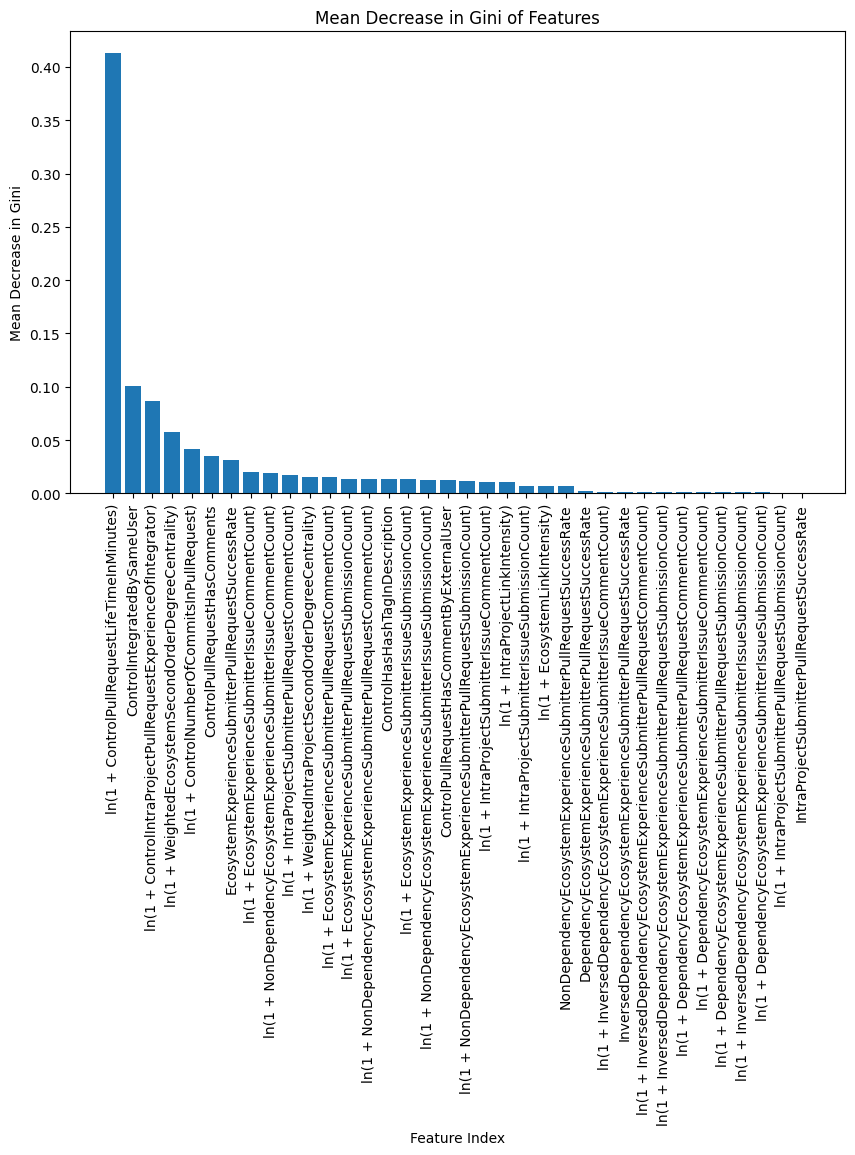

In [15]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.41275128131194805
ControlIntegratedBySameUser: 0.1006252873909137
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.08705175151881646
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.05779293483498476
ln(1 + ControlNumberOfCommitsInPullRequest): 0.04129108945205986
ControlPullRequestHasComments: 0.03465613237972411
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.03147221807476909
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.019743742811159197
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.018884431690605667
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.01720905566977255
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality): 0.01564454279521068
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.015003684438187677
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.01374356589064775
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCo

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [17]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.7214816203172223, 'precision': 0.7734550326578462, 'recall': 0.8183831868443436, 'f1': 0.7952850820547261}


Confusion matrix:
[[15407 13527]
 [10249 46183]]


Classification report:

metrics={'accuracy': 0.7262876755654996, 'precision': 0.7728269787846821, 'recall': 0.8248708737690562, 'f1': 0.7980012794577865}


Confusion matrix:
[[15847 13567]
 [ 9799 46154]]


Classification report:

              precision    recall  f1-score   support

       False       0.60      0.53      0.56     28934
        True       0.77      0.82      0.80     56432

    accuracy                           0.72     85366
   macro avg       0.69      0.68      0.68     85366
weighted avg       0.71      0.72      0.72     85366


              precision    recall  f1-score   support

       False       0.62      0.54      0.58     29414
        True       0.77      0.82      0.80     55953

    accuracy                           0.73     85367
   macro avg       0.70      0.68      0.69     85367
weighted avg       0.72      0.73      0.72     85367


metrics={'accuracy': 0.723417714104982, 'precision': 0.7713884524088128, 'recall': 0.8228455270055812, 'f1': 0.7962865499598802}


Confusion matrix:
[[15610 13676]
 [ 9935 46146]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.53      0.57     29286
        True       0.77      0.82      0.80     56081

    accuracy                           0.72     85367
   macro avg       0.69      0.68      0.68     85367
weighted avg       0.72      0.72      0.72     85367


metrics={'accuracy': 0.7215519059110185, 'precision': 0.7737211567527625, 'recall': 0.8173431734317343, 'f1': 0.7949341753368877}


Confusion matrix:
[[15524 13474]
 [10296 46072]]


Classification report:

              precision    recall  f1-score   support

       False       0.60      0.54      0.57     28998
        True       0.77      0.82      0.79     56368

    accuracy                           0.72     85366
   macro avg       0.69      0.68      0.68     85366
weighted avg       0.72      0.72      0.72     85366


metrics={'accuracy': 0.7239416161000867, 'precision': 0.7718686623200308, 'recall': 0.8222543610620101, 'f1': 0.7962652373130458}


Confusion matrix:
[[15748 13611]
 [ 9955 46052]]


Classification report:

              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29359
        True       0.77      0.82      0.80     56007

    accuracy                           0.72     85366
   macro avg       0.69      0.68      0.68     85366
weighted avg       0.72      0.72      0.72     85366


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.7952850820547261, 0.7980012794577865, 0.7962865499598802, 0.7949341753368877, 0.7962652373130458]
f1_mean=0.7961544648244653, f1_std=0.0010663371090687101

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.6595522860121593, 'precision': 0.660032603469103, 'recall': 0.9986691273024098, 'f1': 0.7947832595448414}


metrics={'accuracy': 0.6536483652933803, 'precision': 0.654077061982599, 'recall': 0.9988181997242466, 'f1': 0.7904966378278029}


Confusion matrix:
[[   25 28988]
 [   75 56279]]


Classification report:

Confusion matrix:
[[   19 29501]
 [   66 55781]]


Classification report:

metrics={'accuracy': 0.6577794438066678, 'precision': 0.6581684706765331, 'recall': 0.9988431899482105, 'f1': 0.7934851762310727}


Confusion matrix:
[[   28 29149]
 [   65 56124]]


Classification report:

metrics={'accuracy': 0.6595482979172036, 'precision': 0.6599971852129856, 'recall': 0.9987044563153318, 'f1': 0.7947687679629407}


Confusion matrix:
[[   29 28990]
 [   73 56274]]


Classification report:

              precision    recall  f1-score   support

       False       0.25      0.00      0.00     29013
        True       0.66      1.00      0.79     56354

    accuracy                           0.66     85367
   macro avg       0.46      0.50      0.40     85367
weighted avg       0.52      0.66      0.53     85367


              precision    recall  f1-score   support

       False       0.22      0.00      0.00     29520
        True       0.65      1.00      0.79     55847

    accuracy                           0.65     85367
   macro avg       0.44      0.50      0.40     85367
weighted avg       0.51      0.65      0.52     85367


              precision    recall  f1-score   support

       False       0.30      0.00      0.00     29177
        True       0.66      1.00      0.79     56189

    accuracy                           0.66     85366
   macro avg       0.48      0.50      0.40     85366
weighted avg       0.54      0.66      0.52     85366


metrics={'accuracy': 0.6567720169622566, 'precision': 0.6571492225792078, 'recall': 0.9989127334949379, 'f1': 0.7927659032718939}


Confusion matrix:
[[   23 29239]
 [   61 56043]]


Classification report:

              precision    recall  f1-score   support

       False       0.28      0.00      0.00     29019
        True       0.66      1.00      0.79     56347

    accuracy                           0.66     85366
   macro avg       0.47      0.50      0.40     85366
weighted avg       0.53      0.66      0.53     85366


              precision    recall  f1-score   support

       False       0.27      0.00      0.00     29262
        True       0.66      1.00      0.79     56104

    accuracy                           0.66     85366
   macro avg       0.47      0.50      0.40     85366
weighted avg       0.53      0.66      0.52     85366


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.7947832595448414, 0.7904966378278029, 0.7934851762310727, 0.7947687679629407, 0.7927659032718939]
f1_mean=0.7932599489677103, f1_std=0.0015828901920487421

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.6474826043155355, 'precision': 0.6587579695332652, 'recall': 0.9635693819074908, 'f1': 0.7825288884713499}


Confusion matrix:
[[ 1131 28046]
 [ 2047 54142]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29177
        True       0.66      0.96      0.78     56189

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.43     85366
weighted avg       0.56      0.65      0.54     85366


metrics={'accuracy': 0.647896728243935, 'precision': 0.6593585949014019, 'recall': 0.9628101378390396, 'f1': 0.7827017335858768}


Confusion matrix:
[[ 1175 27967]
 [ 2091 54134]]


Classification report:

metrics={'accuracy': 0.6463931776116956, 'precision': 0.6573488643548465, 'recall': 0.9642398516087608, 'f1': 0.7817542946382092}


Confusion matrix:
[[ 1117 28181]
 [ 2005 54063]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29142
        True       0.66      0.96      0.78     56225

    accuracy                           0.65     85367
   macro avg       0.51      0.50      0.43     85367
weighted avg       0.56      0.65      0.54     85367


              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29298
        True       0.66      0.96      0.78     56068

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.43     85366
weighted avg       0.55      0.65      0.54     85366


metrics={'accuracy': 0.6469478838427026, 'precision': 0.658262827926228, 'recall': 0.9631813323833274, 'f1': 0.7820515601836787}


Confusion matrix:
[[ 1155 28072]
 [ 2067 54073]]


Classification report:

metrics={'accuracy': 0.6473537473935759, 'precision': 0.6590186693946147, 'recall': 0.9625571426030346, 'f1': 0.7823786253361478}


Confusion matrix:
[[ 1148 27999]
 [ 2105 54114]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29227
        True       0.66      0.96      0.78     56140

    accuracy                           0.65     85367
   macro avg       0.51      0.50      0.43     85367
weighted avg       0.56      0.65      0.54     85367


              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29147
        True       0.66      0.96      0.78     56219

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.43     85366
weighted avg       0.55      0.65      0.54     85366


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7825288884713499, 0.7817542946382092, 0.7827017335858768, 0.7820515601836787, 0.7823786253361478]
f1_mean=0.7822830204430524, f1_std=0.0003400108549070104

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.6595054294985182, 'precision': 0.6599056825113792, 'recall': 0.998650783788102, 'f1': 0.7946854273060542}


Confusion matrix:
[[   47 28991]
 [   76 56253]]


metrics={'accuracy': 0.6584471569477309, 'precision': 0.6586716083555201, 'recall': 0.9990215960436902, 'f1': 0.7939070507156741}


Classification report:

Confusion matrix:
[[   50 29102]
 [   55 56159]]


Classification report:

metrics={'accuracy': 0.6596108566542106, 'precision': 0.66, 'recall': 0.9987042493521247, 'f1': 0.7947707432833291}


              precision    recall  f1-score   support

       False       0.38      0.00      0.00     29038
        True       0.66      1.00      0.79     56329

    accuracy                           0.66     85367
   macro avg       0.52      0.50      0.40     85367
weighted avg       0.57      0.66      0.53     85367


Confusion matrix:
[[   44 28985]
 [   73 56265]]


Classification report:

              precision    recall  f1-score   support

       False       0.48      0.00      0.00     29152
        True       0.66      1.00      0.79     56214

    accuracy                           0.66     85366
   macro avg       0.57      0.50      0.40     85366
weighted avg       0.60      0.66      0.52     85366


              precision    recall  f1-score   support

       False       0.38      0.00      0.00     29029
        True       0.66      1.00      0.79     56338

    accuracy                           0.66     85367
   macro avg       0.52      0.50      0.40     85367
weighted avg       0.56      0.66      0.53     85367


metrics={'accuracy': 0.6560691610242954, 'precision': 0.6567083616906433, 'recall': 0.9981451756732656, 'f1': 0.7922033802338421}


Confusion matrix:
[[   40 29256]
 [  104 55966]]


Classification report:

metrics={'accuracy': 0.6543705925075557, 'precision': 0.6547416573807988, 'recall': 0.9987475398103417, 'f1': 0.7909596514222963}


Confusion matrix:
[[   41 29435]
 [   70 55820]]


Classification report:

              precision    recall  f1-score   support

       False       0.28      0.00      0.00     29296
        True       0.66      1.00      0.79     56070

    accuracy                           0.66     85366
   macro avg       0.47      0.50      0.40     85366
weighted avg       0.53      0.66      0.52     85366


              precision    recall  f1-score   support

       False       0.37      0.00      0.00     29476
        True       0.65      1.00      0.79     55890

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.40     85366
weighted avg       0.56      0.65      0.52     85366


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7946854273060542, 0.7939070507156741, 0.7947707432833291, 0.7922033802338421, 0.7909596514222963]
f1_mean=0.793305250592239, f1_std=0.0014920237082776105

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)'

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.6578654515210796, 'precision': 0.6587013475252294, 'recall': 0.9972253841775754, 'f1': 0.7933608314525658}


Confusion matrix:
[[   92 29051]
 [  156 56068]]


Classification report:

              precision    recall  f1-score   support

       False       0.37      0.00      0.01     29143
        True       0.66      1.00      0.79     56224

    accuracy                           0.66     85367
   macro avg       0.51      0.50      0.40     85367
weighted avg       0.56      0.66      0.52     85367


metrics={'accuracy': 0.6556163388663067, 'precision': 0.6562822921559418, 'recall': 0.9977149793812593, 'f1': 0.7917578642413425}


metrics={'accuracy': 0.6580957289787503, 'precision': 0.6587510271158586, 'recall': 0.9979372277051658, 'f1': 0.7936220611631607}


Confusion matrix:
[[   79 29271]
 [  128 55889]]


Classification report:

Confusion matrix:
[[   60 29071]
 [  116 56119]]


Classification report:

metrics={'accuracy': 0.6573108731813603, 'precision': 0.6580343726521413, 'recall': 0.9977927302502759, 'f1': 0.7930561254085257}


Confusion matrix:
[[   58 29130]
 [  124 56054]]


metrics={'accuracy': 0.6574748729002179, 'precision': 0.6582604099371586, 'recall': 0.9974015341627067, 'f1': 0.7930966162380946}


Classification report:

Confusion matrix:
[[   85 29094]
 [  146 56041]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.00      0.01     29350
        True       0.66      1.00      0.79     56017

    accuracy                           0.66     85367
   macro avg       0.52      0.50      0.40     85367
weighted avg       0.56      0.66      0.52     85367


              precision    recall  f1-score   support

       False       0.34      0.00      0.00     29131
        True       0.66      1.00      0.79     56235

    accuracy                           0.66     85366
   macro avg       0.50      0.50      0.40     85366
weighted avg       0.55      0.66      0.52     85366


              precision    recall  f1-score   support

       False       0.32      0.00      0.00     29188
        True       0.66      1.00      0.79     56178

    accuracy                           0.66     85366
   macro avg       0.49      0.50      0.40     85366
weighted avg       0.54      0.66      0.52     85366


              precision    recall  f1-score   support

       False       0.37      0.00      0.01     29179
        True       0.66      1.00      0.79     56187

    accuracy                           0.66     85366
   macro avg       0.51      0.50      0.40     85366
weighted avg       0.56      0.66      0.52     85366


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7933608314525658, 0.7917578642413425, 0.7936220611631607, 0.7930561254085257, 0.7930966162380946]
f1_mean=0.7929786997007379, f1_std=0.0006434713538319384

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIs

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.6474943185811681, 'precision': 0.6582838797548399, 'recall': 0.9645071627111396, 'f1': 0.7825031079244846}


Confusion matrix:
[[ 1142 28100]
 [ 1992 54132]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29242
        True       0.66      0.96      0.78     56124

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.43     85366
weighted avg       0.56      0.65      0.54     85366


metrics={'accuracy': 0.6457881851300854, 'precision': 0.6569667047693168, 'recall': 0.9638027616227209, 'f1': 0.7813403910679162}


Confusion matrix:
[[ 1104 28209]
 [ 2029 54025]]


Classification report:

              precision    recall  f1-score   support

       False       0.35      0.04      0.07     29313
        True       0.66      0.96      0.78     56054

    accuracy                           0.65     85367
   macro avg       0.50      0.50      0.42     85367
weighted avg       0.55      0.65      0.54     85367


metrics={'accuracy': 0.6471897476747183, 'precision': 0.6588638935189128, 'recall': 0.9630288264897836, 'f1': 0.782425266929623}


Confusion matrix:
[[ 1094 28039]
 [ 2079 54154]]


Classification report:

              precision    recall  f1-score   support

       False       0.34      0.04      0.07     29133
        True       0.66      0.96      0.78     56233

    accuracy                           0.65     85366
   macro avg       0.50      0.50      0.43     85366
weighted avg       0.55      0.65      0.54     85366


metrics={'accuracy': 0.6491928870979078, 'precision': 0.6597189325753987, 'recall': 0.9656508907300074, 'f1': 0.7838931986289014}


Confusion matrix:
[[ 1105 28015]
 [ 1932 54314]]


Classification report:

metrics={'accuracy': 0.6481310108121405, 'precision': 0.6587800908494668, 'recall': 0.9653994019649722, 'f1': 0.7831473165942332}


Confusion matrix:
[[ 1089 28094]
 [ 1944 54240]]


Classification report:

              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29120
        True       0.66      0.97      0.78     56246

    accuracy                           0.65     85366
   macro avg       0.51      0.50      0.43     85366
weighted avg       0.56      0.65      0.54     85366


              precision    recall  f1-score   support

       False       0.36      0.04      0.07     29183
        True       0.66      0.97      0.78     56184

    accuracy                           0.65     85367
   macro avg       0.51      0.50      0.43     85367
weighted avg       0.56      0.65      0.54     85367


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.7825031079244846, 0.7813403910679162, 0.782425266929623, 0.7838931986289014, 0.7831473165942332]
f1_mean=0.7826618562290316, f1_std=0.0008460876508650523

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.6240350486722035, 'precision': 0.6564747036341259, 'recall': 0.9008, 'f1': 0.75947090343613}


Confusion matrix:
[[ 2602 26515]
 [ 5580 50670]]


Classification report:

              precision    recall  f1-score   support

       False       0.32      0.09      0.14     29117
        True       0.66      0.90      0.76     56250

    accuracy                           0.62     85367
   macro avg       0.49      0.50      0.45     85367
weighted avg       0.54      0.62      0.55     85367


metrics={'accuracy': 0.6218210784026614, 'precision': 0.6537396121883656, 'recall': 0.9012455833541525, 'f1': 0.7577949164240915}


Confusion matrix:
[[ 2579 26750]
 [ 5534 50504]]


Classification report:

              precision    recall  f1-score   support

       False       0.32      0.09      0.14     29329
        True       0.65      0.90      0.76     56038

    accuracy                           0.62     85367
   macro avg       0.49      0.49      0.45     85367
weighted avg       0.54      0.62      0.54     85367


metrics={'accuracy': 0.6229060750181571, 'precision': 0.6550082165547404, 'recall': 0.9015316117542297, 'f1': 0.7587478359925954}


Confusion matrix:
[[ 2554 26662]
 [ 5529 50621]]


Classification report:

              precision    recall  f1-score   support

       False       0.32      0.09      0.14     29216
        True       0.66      0.90      0.76     56150

    accuracy                           0.62     85366
   macro avg       0.49      0.49      0.45     85366
weighted avg       0.54      0.62      0.55     85366


metrics={'accuracy': 0.6233395028465666, 'precision': 0.6565758623816371, 'recall': 0.8998384491114702, 'f1': 0.7591965730034151}


Confusion matrix:
[[ 2525 26512]
 [ 5642 50687]]


Classification report:

              precision    recall  f1-score   support

       False       0.31      0.09      0.14     29037
        True       0.66      0.90      0.76     56329

    accuracy                           0.62     85366
   macro avg       0.48      0.49      0.45     85366
weighted avg       0.54      0.62      0.55     85366


metrics={'accuracy': 0.6214652203453366, 'precision': 0.6538461538461539, 'recall': 0.9004173057031779, 'f1': 0.7575734841778324}


Confusion matrix:
[[ 2562 26730]
 [ 5584 50490]]


Classification report:

              precision    recall  f1-score   support

       False       0.31      0.09      0.14     29292
        True       0.65      0.90      0.76     56074

    accuracy                           0.62     85366
   macro avg       0.48      0.49      0.45     85366
weighted avg       0.54      0.62      0.54     85366


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.75947090343613, 0.7577949164240915, 0.7587478359925954, 0.7591965730034151, 0.7575734841778324]
f1_mean=0.7585567426068129, f1_std=0.0007521656614343379



In [18]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.7952850820547261, 0.7980012794577865, 0.7962865499598802, 0.7949341753368877, 0.7962652373130458]
f1_mean=0.7961544648244653, f1_std=0.0010663371090687101

Cluster 'FeatureGroups.Intra':
f1_scores=[0.7947832595448414, 0.7904966378278029, 0.7934851762310727, 0.7947687679629407, 0.7927659032718939]
f1_mean=0.7932599489677103, f1_std=0.0015828901920487421

Cluster 'FeatureGroups.Eco':
f1_scores=[0.7825288884713499, 0.7817542946382092, 0.7827017335858768, 0.7820515601836787, 0.7823786253361478]
f1_mean=0.7822830204430524, f1_std=0.0003400108549070104

Cluster 'FeatureGroups.DEco':
f1_scores=[0.7946854273060542, 0.7939070507156741, 0.7947707432833291, 0.7922033802338421, 0.7909596514222963]
f1_mean=0.793305250592239, f1_std=0.0014920237082776105

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.7933608314525658, 0.7917578642413425, 0.7936220611631607, 0.7930561254085257, 0.7930966162380946]
f1_mean=0.7929786997007379

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [19]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.657966131873899.
{
    "accuracy": 0.5496737615237738,
    "precision": 0.6589163822525598,
    "recall": 0.6581325568595423,
    "f1": 0.6585242363140551
}


In [20]:
import datetime

print(datetime.datetime.now())

2024-02-21 09:39:39.794465
